In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open("dataAll.pickle", "rb") as infile:
    data = pickle.load(infile)

In [3]:
IDs = ['5153', '5300', '5250', '5342', '5214', '5242', '5341', '5245', '5269', '5426', '5154', '5207', '5284', '5297', '5158', '5376', '5259', '5350', '5412', '5264', '5299', '5367', '5282', '5210', '5263', '5358', '5251', '5110', '5186', '5303', '5349', '5352', '5374', '5457', '5322', '5147', '5325', '5351', '5375', '5213', '5323', '5354', '5156', '5310', '5347', '5180', '5379', '5415', '5472', '5149']
print(IDs)

['5153', '5300', '5250', '5342', '5214', '5242', '5341', '5245', '5269', '5426', '5154', '5207', '5284', '5297', '5158', '5376', '5259', '5350', '5412', '5264', '5299', '5367', '5282', '5210', '5263', '5358', '5251', '5110', '5186', '5303', '5349', '5352', '5374', '5457', '5322', '5147', '5325', '5351', '5375', '5213', '5323', '5354', '5156', '5310', '5347', '5180', '5379', '5415', '5472', '5149']


In [4]:
%matplotlib inline
import json
import requests
import time
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pickle
import copy
from collections import defaultdict, Counter
import os
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import pandas as pd
import copy
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
url = "http://localhost:51016/api/DTWNew"

In [5]:
ope = "3.26"
dataAll = defaultdict(list)

batchFiles = [filename for filename in os.listdir("recipe421/") if filename.endswith(".pickle")]
try:
    with open("dataAll.pickle", "rb") as infile:
        dataAll = pickle.load(infile)
except:
    for filename in batchFiles:
        batchId = filename[:4]
        with open("recipe421/{}".format(filename), "rb") as infile:
            batchData = pickle.load(infile)
        for tagName, pv in batchData['Units']['3']['Operations'][ope]['PVs'].items():
            if len(pv) > 1:
                pv['name'] = pv['TagName']
                _ = pv.pop('TagName')
                dataAll[batchId].append(pv)
        #print(len(dataAll[batchId]), end = " ")
    with open("dataAll.pickle", "wb") as handle:
        pickle.dump(dataAll, handle, protocol=pickle.HIGHEST_PROTOCOL)

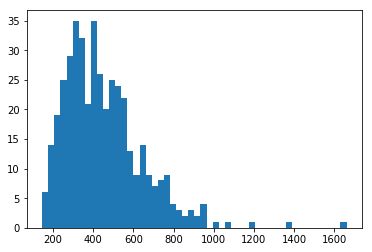

In [6]:
opeLen = list()
pvDataset = list()
for _id, pvs in dataAll.items():
    opeLen.append((len(pvs[0]['values']), _id))
    pvList = list()
    for pv in pvs:
        pvList.append(pv['name'])
    pvDataset.append(pvList)
plt.hist([l for l, _id in opeLen], bins=50)
plt.show()

In [7]:
print("Min: {}\nMax: {}\nMedian: {}\nMean: {:.02f}".format(min([l for l, _id in opeLen]), max([l for l, _id in opeLen]), np.median([l for l, _id in opeLen]), np.mean([l for l, _id in opeLen])))

Min: 146
Max: 1661
Median: 415.0
Mean: 452.32


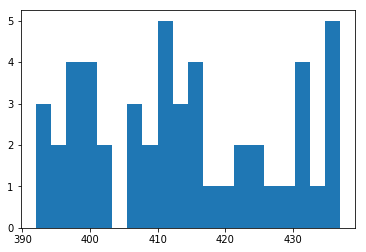

In [8]:
medLen = np.median([l for l, _id in opeLen])

# Select the N=50 closest to the median bacthes
# center around the median
centered = [(abs(l-medLen), _id) for l, _id in opeLen]
selected = sorted(centered)[:50]
plt.hist([l for l, _id in opeLen if _id in [ID for d, ID in selected]], bins = 20)
plt.show()

In [9]:
IDs = list(dataAll.keys())
for _id in IDs:
    L = len(dataAll[_id])
    if L != 99:
        dataAll.pop(_id)
print(len(dataAll))

294


In [10]:
data = dict()
for d, _id in selected:
    data[_id] = copy.copy(dataAll[_id])
print(len(data))
print(data.keys())
IDs = list(data.keys())

50
dict_keys(['5153', '5300', '5250', '5342', '5214', '5242', '5341', '5245', '5269', '5426', '5154', '5207', '5284', '5297', '5158', '5376', '5259', '5350', '5412', '5264', '5299', '5367', '5282', '5210', '5263', '5358', '5251', '5110', '5186', '5303', '5349', '5352', '5374', '5457', '5322', '5147', '5325', '5351', '5375', '5213', '5323', '5354', '5156', '5310', '5347', '5180', '5379', '5415', '5472', '5149'])


In [11]:
data['reference'] = selected[0][1]
data['reference']
#_ = data.pop('5091') # problems, yet to understand

'5153'

In [12]:
pvNames = [(pv['name'], j) for pv, j in zip(data[data['reference']], range(len(data[data['reference']])))]    

In [13]:
PVsDict = {j: pv['name'] for j, pv in zip(range(len(data['5153'])), data['5153'])}
constPVs = []
for j in PVsDict.keys():
    zeroVar = True
    for _id, pvs in data.items():
        if _id != "reference":
            var = np.var(pvs[j]['values'])
            if var > 1e-6:
                zeroVar = False
    if zeroVar:
        constPVs.append(j)
print(constPVs, len(constPVs))


[0, 6, 7, 8, 9, 10, 16, 17, 20, 22, 23, 33, 34, 35, 36, 37, 38, 39, 40, 43, 48, 49, 50, 51, 55, 56, 57, 58, 59, 62, 63, 64, 65, 68, 75, 76, 78, 79, 80, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98] 52


In [14]:
for j in constPVs:
    _ = PVsDict.pop(j)
PVsDict

{1: 'ba_FQ2Qyx',
 2: 'ba_FQADMQfb0z',
 3: 'ba_FQYXdr6Q0',
 4: 'ba_FQNOJG',
 5: 'ba_FQnZKYLSO02xLf',
 11: 'ba_FCobtZJfb5TG',
 12: 'ba_FC7fl4f1HT5',
 13: 'ba_FCywcBXpqpo',
 14: 'ba_FC7NvzX',
 15: 'ba_FIhgSwHD',
 18: 'ba_FC3BnZ',
 19: 'ba_FCFGHiEU9Kn',
 21: 'ba_FmYOrhonkk',
 24: 'ba_PLAu1m2',
 25: 'ba_PCPUSq5ah',
 26: 'ba_SinhbKA',
 27: 'ba_TIJSj',
 28: 'ba_TrWfpiPrs',
 29: 'ba_TC06nRC',
 30: 'ba_TCyNE8Mdv',
 31: 'ba_TZNCmUn29mO',
 32: 'ba_Fl7pvjqC',
 41: 'ba_ErguU',
 42: 'ba_FpxlMOAyc5',
 44: 'ba_PCGd0srEZp',
 45: 'ba_PCLAMr1nuoSiAr',
 46: 'ba_PCSTgdwK3V',
 47: 'ba_PCG6Z9',
 52: 'ba_TCzWpXo',
 53: 'ba_TCfg3Yxn',
 54: 'ba_TCkwAse0bopy8zp6',
 60: 'ba_FCGUglDXyPKrnk38',
 61: 'ba_FCDvhG4',
 66: 'ba_TDZyHMh1UZ',
 67: 'ba_TDZV2zDOrmiYP',
 69: 'ba_PfrAayv8',
 70: 'ba_FQT7dzM2wq51Z3JW',
 71: 'ba_FQh8rKXE0',
 72: 'ba_FQ1kbQwOUVlR',
 73: 'ba_FQraEXT',
 74: 'ba_FQVzNY',
 77: 'ba_FQC6tzztBV4DeXemfp',
 81: 'ba_TZv9w2dOu',
 82: 'ba_TZIm086h',
 83: 'ba_TZHx41ABpBbhN',
 84: 'ba_TZWZNzFFdHb',
 96: 'ba_PC

In [15]:
def filterPVs(data, pvSet):
    out = defaultdict(list)
    for key, item in data.items():
        if key != 'reference':
            for idx in pvSet:
                out[key].append(item[idx])

    return out

In [16]:
def pairwiseDist(refBatch, queryBatch):
    dist = 0
    scale = MinMaxScaler()
    for name, pv in refBatch.items():
        x = scale.fit_transform(X=np.array(pv['values']).reshape(-1,1))
        y = scale.fit_transform(X=np.array(queryBatch[name]['values']).reshape(-1,1))
        dist += np.linalg.norm(x-y, ord=2)**2
    return np.sqrt(dist)

In [17]:
def groupProcess(dataRaw, pvs, refId):
    # filter pvs
    output = list()
    data = filterPVs(dataRaw, pvs)
    data['reference'] = refId
    
    batchIds = [key for key in data.keys() if key != 'reference' and key!= refId]
    
    # align bacthes
    ok = False
    while not ok:
        try:
            result = json.loads(requests.post(url,json=json.dumps(data)).text)
            ok = True
        except:
            time.sleep(1)
    
    #compute distance and save results
    refBatch = result[refId]
    res = {"refId" : refId,
          "queryId": 0,
          "DTW_dist": 0,
          "PVs": pvs}
    for _id in batchIds:
        try:
            queryBatch = result[_id]
            res['queryId'] = _id
            res['DTW_dist'] = pairwiseDist(refBatch, queryBatch)
        except:
            res['queryId'] = _id
            res['DTW_dist'] = np.nan
        output.append(copy.deepcopy(res))
    
    return output

In [18]:
def analysis(refId, data, pvs, groupSize):
    # group ids
    
    data['reference'] = refId
    keys = [key for key in data.keys() if key != 'reference' and key != refId]

    groupIds = [keys[i*groupSize:(i+1)*groupSize] for i in range(0,len(keys)//groupSize+1)]
    L = len(groupIds)
    for group in groupIds:
        print(L, end = " ")
        L -= 1
        dataGroup = dict()
        dataGroup[refId] = copy.copy(data[refId])
        dataGroup['reference'] = refId
        for _id in group:
            dataGroup[_id] = data[_id]
            
        for pvIds in pvs:
            yield groupProcess(dataGroup, pvIds, refId)

In [19]:
def oneMorePV(selectedPVs, folder, data):
    ids = [key for key in data.keys() if key != 'reference']
    L = len(ids)
    
    try : os.mkdir("operation3_26/{}".format(folder))
    except: pass
    
    for refId in ids:
        print(L)
        if "Operation3_26_{}.csv".format(refId) not in os.listdir("operation3_26/{}/".format(folder)):
            df = pd.DataFrame()
            #start = time.time()

            for res in analysis(refId, data, [selectedPVs + [i] for i in PVsDict.keys() if i not in selectedPVs], groupSize=25):
                df = df.append(pd.DataFrame(res), ignore_index=True)
            #print("Elapsed {:.0f} seconds".format(time.time() - start), end = "")
            print("")

            df.to_csv("operation3_26/{}/Operation3_26_{}.csv".format(folder, refId), header = True, index = False)
        L -= 1
        if L%10 == 0: clear_output()
    clear_output()
    print("Done")

In [20]:
selectedPVs = []

In [21]:
oldKeys = [1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 18, 19, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 41, 42, 44, 45, 46, 47, 52, 53, 54, 60, 61, 66, 67, 69, 70, 71, 72, 73, 74, 77, 81, 82, 83, 84, 96]
newKeys = [1, 3, 4, 5, 13, 15, 18, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 41, 45, 46, 47, 54, 60, 61, 66, 67, 69, 74, 81, 82, 83, 84]
for key in oldKeys:
    if key not in newKeys:
        try: _ = PVsDict.pop(key)
        except: pass
print(oldKeys)
print(newKeys)
print(list(PVsDict.keys()))

[1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 18, 19, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 41, 42, 44, 45, 46, 47, 52, 53, 54, 60, 61, 66, 67, 69, 70, 71, 72, 73, 74, 77, 81, 82, 83, 84, 96]
[1, 3, 4, 5, 13, 15, 18, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 41, 45, 46, 47, 54, 60, 61, 66, 67, 69, 74, 81, 82, 83, 84]
[1, 3, 4, 5, 13, 15, 18, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 41, 45, 46, 47, 54, 60, 61, 66, 67, 69, 74, 81, 82, 83, 84]


In [22]:
folder = "1variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46]': 42, '[25]': 4, '[3]': 3, '[45]': 1})


In [23]:
selectedPVs.append(46)
selectedPVs

[46]

Code to remove non constant but still non informative variables

In [24]:
toRemove = 
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df[df.PVs != '[{}]'.format(toRemove)]
        df.to_csv("operation3_26/{}/{}".format(folder, file), index = False)
_ = PVsDict.pop(toRemove)

SyntaxError: invalid syntax (<ipython-input-24-170ee3221e0f>, line 1)

In [25]:
folder = "2variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3]': 30, '[46, 30]': 9, '[46, 45]': 7, '[46, 25]': 3, '[46, 83]': 1})


In [26]:
selectedPVs.append(3)
selectedPVs

[46, 3]

In [27]:
folder = "3variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25]': 40, '[46, 3, 66]': 3, '[46, 3, 45]': 3, '[46, 3, 30]': 3, '[46, 3, 67]': 1})


In [28]:
selectedPVs.append(25)
selectedPVs

[46, 3, 25]

In [29]:
folder = "4variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66]': 20, '[46, 3, 25, 30]': 10, '[46, 3, 25, 67]': 10, '[46, 3, 25, 45]': 9, '[46, 3, 25, 18]': 1})


In [30]:
selectedPVs.append(66)
selectedPVs

[46, 3, 25, 66]

In [31]:
folder = "5variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67]': 20, '[46, 3, 25, 66, 30]': 17, '[46, 3, 25, 66, 45]': 11, '[46, 3, 25, 66, 84]': 1, '[46, 3, 25, 66, 82]': 1})


In [32]:
selectedPVs.append(67)
selectedPVs

[46, 3, 25, 66, 67]

In [33]:
folder = "6variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30]': 31, '[46, 3, 25, 66, 67, 45]': 15, '[46, 3, 25, 66, 67, 84]': 3, '[46, 3, 25, 66, 67, 29]': 1})


In [34]:
selectedPVs.append(30)
selectedPVs

[46, 3, 25, 66, 67, 30]

In [35]:
folder = "7variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30, 84]': 28, '[46, 3, 25, 66, 67, 30, 83]': 14, '[46, 3, 25, 66, 67, 30, 45]': 7, '[46, 3, 25, 66, 67, 30, 29]': 1})


In [36]:
selectedPVs.append(84)
selectedPVs

[46, 3, 25, 66, 67, 30, 84]

In [37]:
folder = "8variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30, 84, 83]': 44, '[46, 3, 25, 66, 67, 30, 84, 45]': 5, '[46, 3, 25, 66, 67, 30, 84, 29]': 1})


In [38]:
selectedPVs.append(83)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83]

In [39]:
folder = "9variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30, 84, 83, 45]': 46, '[46, 3, 25, 66, 67, 30, 84, 83, 54]': 3, '[46, 3, 25, 66, 67, 30, 84, 83, 29]': 1})


In [40]:
selectedPVs.append(45)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45]

In [41]:
folder = "10variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30, 84, 83, 45, 54]': 36, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 29]': 11, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 18]': 2, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 82]': 1})


In [42]:
selectedPVs.append(54)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54]

In [43]:
folder = "11variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29]': 32, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 18]': 17, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 81]': 1})


In [44]:
selectedPVs.append(29)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29]

In [45]:
folder = "12variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18]': 32, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 82]': 12, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 81]': 6})


In [46]:
selectedPVs.append(18)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18]

In [47]:
folder = "13variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82]': 25, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 81]': 17, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 61]': 8})


In [48]:
selectedPVs.append(82)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82]

In [49]:
folder = "14variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81]': 40, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 61]': 10})


In [50]:
selectedPVs.append(81)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81]

In [51]:
folder = "15variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61]': 45, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 27]': 2, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 60]': 2, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 15]': 1})


In [52]:
selectedPVs.append(61)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61]

In [53]:
folder = "16variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60]': 40, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 27]': 7, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 15]': 3})


In [54]:
selectedPVs.append(60)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60]

In [55]:
folder = "17variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27]': 39, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 15]': 7, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 28]': 2, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 21]': 1, '[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 69]': 1})


In [56]:
selectedPVs.append(27)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27]

In [64]:
folder = "18variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(*["{}: {}".format(key, item) for key, item in Counter(firstChoice).items()], sep = "\n")

Done
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15]: 33
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 21]: 2
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 69]: 3
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 28]: 9
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 47]: 2
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 41]: 1


In [58]:
selectedPVs.append(15)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15]

In [69]:
folder = "19variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(*["{}: {}".format(key, item) for key, item in sorted(list(Counter(firstChoice).items()), key = lambda x: x[1], reverse = True)], sep = "\n")

Done
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69]: 17
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 28]: 14
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 47]: 9
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 21]: 5
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 41]: 2
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 4]: 1
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 26]: 1
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 1]: 1


In [70]:
selectedPVs.append(69)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69]

In [71]:
folder = "20variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(*["{}: {}".format(key, item) for key, item in sorted(list(Counter(firstChoice).items()), key = lambda x: x[1], reverse = True)], sep = "\n")

Done
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28]: 21
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 47]: 13
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 21]: 9
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 26]: 3
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 1]: 2
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 41]: 2


In [72]:
selectedPVs.append(28)
selectedPVs

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28]

In [75]:
folder = "21variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(*["{}: {}".format(key, item) for key, item in sorted(list(Counter(firstChoice).items()), key = lambda x: x[1], reverse = True)], sep = "\n")

Done
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28, 47]: 25
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28, 21]: 12
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28, 41]: 7
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28, 26]: 3
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28, 1]: 3


In [76]:
selectedPVs.append(47)
print(selectedPVs)

[46,
 3,
 25,
 66,
 67,
 30,
 84,
 83,
 45,
 54,
 29,
 18,
 82,
 81,
 61,
 60,
 27,
 15,
 69,
 28,
 47]

In [77]:
folder = "22variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(*["{}: {}".format(key, item) for key, item in sorted(list(Counter(firstChoice).items()), key = lambda x: x[1], reverse = True)], sep = "\n")

Done
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28, 47, 21]: 18
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28, 47, 1]: 17
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28, 47, 41]: 8
[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28, 47, 26]: 7


In [78]:
selectedPVs.append(21)
print(selectedPVs)

[46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28, 47, 21]


In [ ]:
folder = "23variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(*["{}: {}".format(key, item) for key, item in sorted(list(Counter(firstChoice).items()), key = lambda x: x[1], reverse = True)], sep = "\n")

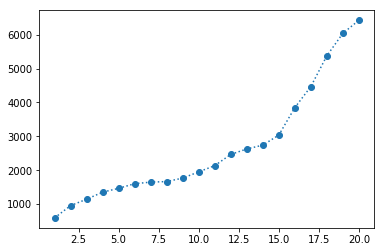

In [74]:
feats = [46, 3, 25, 66, 67, 30, 84, 83, 45, 54, 29, 18, 82, 81, 61, 60, 27, 15, 69, 28, 47, 21]

varDist = []
for i in range(1,len(os.listdir("operation3_26/"))):
    folder = "{}variate".format(i)
    firstChoice = list()
    for file in os.listdir("operation3_26/{}/".format(folder)):
        if file.endswith(".csv"):
            df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
            df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
            df.sort_values(by="DTW_dist", ascending= True, inplace= True)
            firstChoice.append(df.index[0])
   
    count = Counter(firstChoice)
    mostCommon = count.most_common()[0][0]

    dist = 0
    for file in os.listdir("operation3_26/{}/".format(folder)):
        if file.endswith(".csv"):
            df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
            df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
            dist += df.loc[mostCommon, "DTW_dist"]
    varDist.append((i, dist/np.sqrt(i))) # dimensionality problem

plt.plot([x for x,y in varDist], [y for x, y in varDist], "o:")
plt.show()

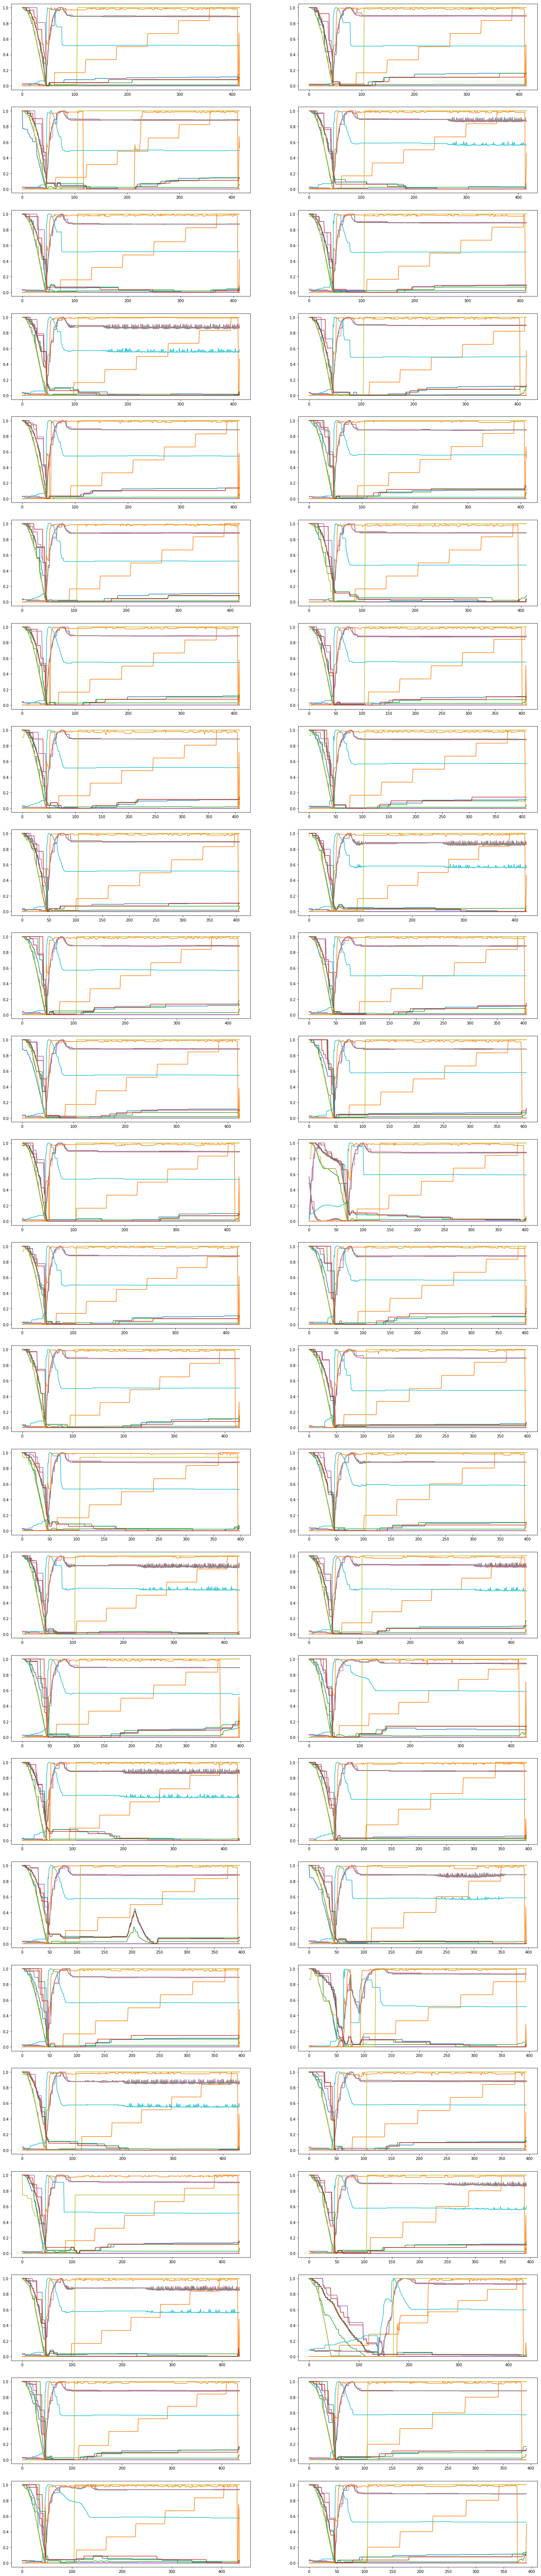

In [67]:
ncols = 2
nrows = 25
fig, ax = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_figwidth(25)
fig.set_figheight(125)
pvIdx = [idx for idx in selectedPVs]#[key for key in PVsDict.keys()]#
scale = MinMaxScaler()
for i, _id in zip(range(50), IDs):
    x = np.unravel_index([i], (nrows, ncols))[0][0]
    y = np.unravel_index([i], (nrows, ncols))[1][0]
    for idx in pvIdx:
        ax[x, y].plot(scale.fit_transform(np.array(data[_id][idx]['values']).reshape(-1, 1)))
plt.show()

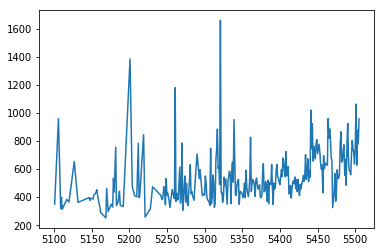

In [67]:
d = list()
for key, item in dataAll.items():
    if key != "reference":
        d.append((int(key), len(item[0]['values'])))
d = sorted(d)
plt.plot([x for x, y in d], [y for x, y in d])
plt.show()